In [1]:
%matplotlib inline
# Add the directory containing the package to sys.path

import sys, os
package_dir = os.path.abspath("C:/Users/froll/Documents/Labo/Projets/Violon/ManipViolon_Anech_08062023")
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)
package_dir = os.path.abspath("C:/Users/froll/Documents/Labo/Projets/Violon/ManipViolon_Anech_08062023/array-processing/toolboxes")
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)
package_dir = os.path.abspath("C:/Users/froll/Documents/Labo/Projets/Outils/swd")
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)
from swd import spherical_processing as sp
from swd import geotools as geo
from swd import plots as splots
import swd as swd
import importlib

importlib.reload(swd.plots)

import numpy as np
import matplotlib.pyplot as plt
import warnings
from utils_DirViolins import *
warnings.filterwarnings("ignore")
from tqdm import tqdm
np.set_printoptions(precision=2, suppress=True)
from IPython.display import display, clear_output
import mpld3
# Enable LaTeX rendering
plt.rc('text', usetex=True)


In [2]:
#Vitesse du son au moment de la mesure, dependant de la temperature:
Tc = 21.5 
C = np.sqrt( 1.4 * 287 *(Tc + 273) )
NbViol = 6
OSH = 7

NbSH = (OSH+1)**2
frq = np.load('ViolinsPm.npz')['frq']
NumViolon = [1,4,5,9,11,13]
Cmn = np.load(f'Cmn.npz')['Cmn']
frq = frq[:Cmn.shape[2]]
Diag = np.load(f'Diag.npz')['Diag']
angles_look = np.load(f'Diag.npz')['angles_look']

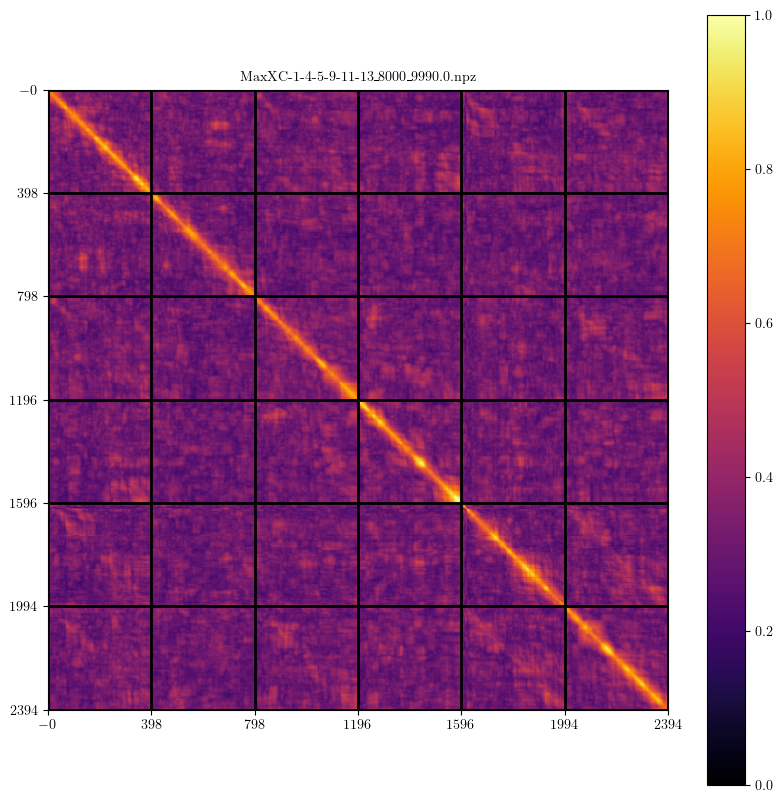

In [9]:
f1 = 8000
f2 = np.min((10000, np.max(frq)))
df = frq[2] - frq[1]
ixf1 = np.argmin(np.abs(frq-f1))
ixf2 = np.argmin(np.abs(frq-f2))
Csh = Cmn[:,:,ixf1:ixf2+1]
fvect = np.arange(f1, f2+df, df)
kvect = 2*np.pi*fvect.T/C
Nbf = len(fvect)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

# Initialize the plots
c1 = axs.imshow(np.empty((NbViol*Nbf,NbViol*Nbf)), cmap='inferno', aspect='equal', interpolation='none')
axs.set_title('XC')
axs.grid(True, which='both', linestyle='-', linewidth=2, color='k')
# Set the ticks on the x-axis and y-axis
axs.set_xticks(np.arange(-0.50, Nbf*NbViol, Nbf))  # Set x-ticks from 0 to 10 with a step of 1
axs.set_yticks(np.arange(-0.50, Nbf*NbViol, Nbf))  # Set y-ticks from -1 to 1 with a step of 0.5
# Add colorbars
fig.colorbar(c1, ax=axs)

def update_plots():
    c1.set_data(MaxXC/np.max(MaxXC))
    c1.set_clim(0, 1)
    clear_output(wait=True)
    display(fig)
    plt.pause(0.01)
    
Csh[Csh==0] = 1e-10

H_farfield_dir = np.sin(angles_look[:,0][:,None])*sp.compute_FFD_transfer_matrix(angles_look=angles_look, N_SH=OSH)


SelectedViol = np.array([0,1,2,3,4,5])
NbViol = len(SelectedViol)
ListViol = ""
for n in range(NbViol): 
    ListViol += f"-{NumViolon[n]}"
    
FileName = f'MaxXC{ListViol:s}_{f1}_{f2}.npz'
MaxXC = np.zeros((Nbf*NbViol, Nbf*NbViol))
PHC = np.zeros((Nbf*NbViol, Nbf*NbViol))
THC = np.zeros((Nbf*NbViol, Nbf*NbViol))
K = np.arange((NbViol**2*Nbf))
np.random.shuffle(K)
I = np.arange(NbViol*Nbf)
J = np.arange(NbViol)
IJ = np.meshgrid(I,J)
I = IJ[0].flatten()
J = IJ[1].flatten()
ii = 0
for k in tqdm(K):
    ii += 1
    i = I[k]
    j = J[k]

    v = i//Nbf
    ixf = i%Nbf
    w = j
    C1 = Csh[w,:,:]
    C2 = Csh[v,:,ixf]
    eC1 = np.sum(np.abs(C1)**2, axis = 0)
    eC2 = np.sum(np.abs(C2)**2)
    SXC = C1 * np.conj(C2[:,None])
    DXC = np.zeros(((angles_look.shape[0], Nbf)), dtype = complex)
    for ind_k in range(Nbf):
        DXC[:, ind_k] = H_farfield_dir@SXC[:, ind_k] 
    DXC = DXC/np.sqrt(eC1*eC2)   
    
    mac = np.max(np.abs(DXC), axis = 0  )
    m = w*Nbf 
    n = v*Nbf + ixf 
    
    MaxXC[m:m+Nbf, n] = mac
    
    THC[m:m+Nbf, n] = angles_look[np.argmax(np.abs(DXC), axis = 0),0]
    PHC[m:m+Nbf, n] = angles_look[np.argmax(np.abs(DXC), axis = 0),1]
    axs.set_title(FileName)
    if ii%100== 0:
        update_plots()  
        np.savez(FileName, MaxXC = MaxXC, THC = THC, PHC = PHC)
update_plots()
np.savez(FileName, MaxXC = MaxXC, THC = THC, PHC = PHC)        


In [ ]:
f1 = 2
f2 = 15000
logscale = np.logspace(np.log10(f1), np.log10(f2), num=120)

# Clip logscale values to the range of frq
logscale = np.clip(logscale, 10,4900)

# Find the closest indices in frq
ixf = [np.argmin(np.abs(f - frq)) for f in logscale]

# Use the valid indices
Csh = Cmn[:, :, ixf]
fvect = frq[ixf]
kvect = 2 * np.pi * fvect.T / C
Nbf = len(fvect)

plt.plot(ixf)

In [ ]:

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
c1 = axs.imshow(np.empty((NbViol*Nbf,NbViol*Nbf)), cmap='inferno', aspect='equal', interpolation='none')
axs.set_title('XC')
axs.grid(True, which='both', linestyle='-', linewidth=2, color='k')
axs.set_xticks(np.arange(-0.50, Nbf*NbViol, Nbf))  # Set x-ticks from 0 to 10 with a step of 1
axs.set_yticks(np.arange(-0.50, Nbf*NbViol, Nbf))  # Set y-ticks from -1 to 1 with a step of 0.5
fig.colorbar(c1, ax=axs)

def update_plots():
    c1.set_data(MaxXC)
    c1.set_clim(0, np.max(MaxXC))
    clear_output(wait=True)
    display(fig)
    plt.pause(0.01)
    
Csh[Csh==0] = 1e-10

H_farfield_dir = sp.compute_FFD_transfer_matrix(angles_look=angles_look, N_SH=OSH)

SelectedViol = np.array([0,1,2,3,4,5])
NbViol = len(SelectedViol)
ListViol = ""
for n in range(NbViol): 
    ListViol += f"-{NumViolon[n]}"
    
FileName = f'MaxXC{ListViol:s}_{f1}_{f2}.npz'
MaxXC = np.zeros((Nbf*NbViol, Nbf*NbViol))
PHC = np.zeros((Nbf*NbViol, Nbf*NbViol))
THC = np.zeros((Nbf*NbViol, Nbf*NbViol))
K = np.arange((NbViol**2*Nbf))
np.random.shuffle(K)
I = np.arange(NbViol*Nbf)
J = np.arange(NbViol)
IJ = np.meshgrid(I,J)
I = IJ[0].flatten()
J = IJ[1].flatten()

for k in tqdm(K):
    i = I[k]
    j = J[k]

    v = i//Nbf
    ixf = i%Nbf
    w = j
    C1 = Csh[w,:,:]
    C2 = Csh[v,:,ixf]
    SXC = C1 * np.conj(C2[:,None])/(np.abs(C1)*np.abs(C2[:,None]))
    
    N_k = len(kvect)
    DXC = np.zeros(((angles_look.shape[0], N_k)), dtype = complex)
    for ind_k in range(N_k):
        DXC[:, ind_k] = H_farfield_dir@SXC[:, ind_k] # Add the phase factor in the product
    mac = np.max(np.abs(DXC), axis = 0  )
    m = w*Nbf 
    n = v*Nbf + ixf 
    
    MaxXC[m:m+Nbf, n] = mac
    
    THC[m:m+Nbf, n] = angles_look[np.argmax(np.abs(DXC), axis = 0),0]
    PHC[m:m+Nbf, n] = angles_look[np.argmax(np.abs(DXC), axis = 0),1]
    axs.set_title(FileName)

    update_plots()
    np.savez(FileName, MaxXC = MaxXC, THC = THC, PHC = PHC)


In [ ]:

print(fvect[-2])
    

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
MAC = np.load(FileName)['MAC']
PHC = np.load(FileName)['PHC']*180/np.pi
THC = np.load(FileName)['THC']*180/np.pi
# Initialize the plots
c1 = axs[0].imshow(PHC, cmap='hsv', aspect='equal', interpolation='none')
axs[0].set_title('PHXC')
axs[0].grid(True, which='both', linestyle='-', linewidth=2, color='k')
# Set the ticks on the x-axis and y-axis
axs[0].set_xticks(np.arange(-0.50, Nbf*NbViol, Nbf))  # Set x-ticks from 0 to 10 with a step of 1
axs[0].set_yticks(np.arange(-0.50, Nbf*NbViol, Nbf))  # Set y-ticks from -1 to 1 with a step of 0.5
# Add colorbars
fig.colorbar(c1, ax=axs)
MIC = PHC
c1.set_data(MIC)
#c1.set_clim(0, 1)
    
c2 = axs[1].imshow(THC, cmap='hsv', aspect='equal', interpolation='none')
axs[1].set_title('THXC')
axs[1].grid(True, which='both', linestyle='-', linewidth=2, color='k')
# Set the ticks on the x-axis and y-axis
axs[1].set_xticks(np.arange(-0.50, Nbf*NbViol, Nbf))  # Set x-ticks from 0 to 10 with a step of 1
axs[1].set_yticks(np.arange(-0.50, Nbf*NbViol, Nbf))  # Set y-ticks from -1 to 1 with a step of 0.5
# Add colorbars
MIC = THC
c2.set_data(MIC)
#c2.set_clim(0, 1)


In [ ]:
import re

NbV = 3
V = [1,4,5,9,11,13]
MAC = np.zeros((NbV*Nbf, NbV*Nbf))
# Create a figure with 3 subplots in 1 row
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Initialize the plots
c = ax.imshow(MAC, cmap='inferno', aspect='equal', interpolation='none')
ax.set_title('MAC for violin pairs')
# Add colorbars
fig.colorbar(c, ax=ax)

def update_plots():
    c.set_data(MAC)
    c.set_clim(np.min(MAC[MAC!=0]), np.max(MAC))
    clear_output(wait=True)
    display(fig)
    plt.pause(1)
    

DejaFait = [file for file in os.listdir('./',) if file.startswith('MAC-')]
if DejaFait:
    for file in DejaFait:
        nbrs = [int(s) for s in re.findall(r'\d+', file)]
        f1DF = int(nbrs[-2])
        f2DF = int(nbrs[-1])
        ixf1DF = np.argmin(np.abs(f-f1DF))
        ixf2DF = np.argmin(np.abs(f-f2DF))
        NbfDF = ixf2DF-ixf1DF
        VDF = [int(s) for s in nbrs[:-2]]
        MACDF = np.load(file)['MAC']
        PHCDF = np.load(file)['PHC']
        THCDF = np.load(file)['THC']
        mnFilled = np.argwhere(MACDF != 0)    
        mDF = mnFilled[:,0] 
        nDF = mnFilled[:,1]   
        vDF = mDF//NbfDF
        ixfDF = mDF%NbfDF + ixf1DF
        wDF = nDF//NbfDF
        ixgDF = nDF%NbfDF + ixf1DF
      #  V = [i for i in Violins if i in VDF]
        MAC[vDF*Nbf + ixfDF, wDF*Nbf + ixgDF] = MAC[mDF,nDF]
    #update_plots()

# plt.show()


In [ ]:
import re

NbViolAll = 6
NbfAll = len(frq)
MACAll = np.zeros((NbViolAll*NbfAll, NbViolAll*NbfAll))

# Create a figure with 3 subplots in 1 row
figAll, axAll = plt.subplots(1, 1, figsize=(15, 15));

# Initialize the plots
cAll = axAll.imshow(MACAll, cmap='inferno', aspect='equal', interpolation='none')
axAll.set_title('MAC for all violin pairs')
# Add colorbars
figAll.colorbar(cAll, ax=axAll)

def update_plots():
    cAll.set_data(MACAll)
    cAll.set_clim(np.min(MACAll[MACAll!=0]), np.max(MACAll))
    clear_output(wait=True)
    display(figAll)
    plt.pause(1)
    

DejaFait = [file for file in os.listdir('./',) if file.startswith('MAC-')]
if DejaFait:
    for file in DejaFait:
        nbrs = [int(s) for s in re.findall(r'\d+', file)]
        f1 = int(nbrs[-2])
        f2 = int(nbrs[-1])
        ixf1 = np.argmin(np.abs(f-f1))
        ixf2 = np.argmin(np.abs(f-f2))
        Nbf = ixf2-ixf1
        vs =[int(s) for s in nbrs[:-2]]
        MAC = np.load(file)['MAC']
        PHC = np.load(file)['PHC']
        THC = np.load(file)['THC']
        mnFilled = np.argwhere(MAC != 0)    
        m = mnFilled[:,0] 
        n = mnFilled[:,1]   
        v = m//Nbf
        ixf = m%Nbf + ixf1
        w = n//Nbf
        ixg = n%Nbf + ixf1
        MACAll[v*NbfAll + ixf, w*NbfAll + ixg] = MAC[m,n]
        update_plots()

plt.show()
